In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os, sys
from scipy import interpolate
import cartopy.crs as ccrs
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import LineCollection
from matplotlib import cm
from datetime import datetime
import pickle, warnings

In [7]:
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/traj/"))
from traj_psd_obs import traj_psd
from plotting_utilities import *
from flighttrack import *
from thermodynamic_functions import *

farbe = sim_colors()

# Figure 1: Domain topography + flight track and trajectory sample

In [5]:
# Domain topography map
file = '/work/bb1018/b380459/TROPIC/extpar/extpar_icon-grid_tropic_55e170e5s40n_R2500m_bitmap.nc'
dset = xr.open_dataset(str(file))
x, y = dset['lon'].values, dset['lat'].values  # shape = (9648304,)

# Flight 7 track
basedir = '/work/bb1018/b380873/tropic_vis/'
scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
sc_data = xr.open_dataset(scfi)
lat_sc = sc_data['BEST:LAT'].values
lon_sc = sc_data['BEST:LON'].values
t_sc = sc_data['time'].values
i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a coloramp by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

In [7]:
# Read in a full 51-hour long trajectory file. Initialize empty arrays for altitude, latitude, longitude.
basedir = '/scratch/b/b380873/traj_full51h_fast/'
pi = 3.141592653589793238
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/pf/b/b380873/conda-envs/ncplot/lib/python3.7/site-packages/cartopy/data/raster/natural_earth"

# Below the file is just a sample one.
fi_name = basedir + 'traj_tst00000450_p011.nc'
timesteps = 7651
numtraj = xr.open_dataset(fi_name).dims['id']

traj_alt = np.zeros((timesteps,numtraj))
traj_lat = np.zeros((timesteps,numtraj))
traj_lon = np.zeros((timesteps,numtraj))

In [8]:
# Read in the altitude, longitude, latitude values
fi = xr.open_dataset(fi_name)
alt = fi.alt.values
lon = fi.lon.values
lat = fi.lat.values
t = fi.t.values
rtime = fi.rtime.values

# Find indices where the matrix != 0.
xs, ys = np.where(alt != 0)
# Extract the square with extreme limits.
# In limited testing, this seems always to generate [=] (88,5308)
alt = alt[:max(xs)+1,:max(ys)+1]
lon = lon[:max(xs)+1,:max(ys)+1]
lat = lat[:max(xs)+1,:max(ys)+1]
rtime = rtime[:max(xs)+1]

In [9]:
# Store the trimmed matrices.
temp1 = alt/1000.
temp2 = rad2deg(lat)
temp3 = rad2deg(lon)

# Mask the negative altitudes and fill values (-999.) for latitudes and longitudes.
traj_alt = np.where((temp1 > 0), temp1, np.nan)
traj_lat = np.where((temp2 >= -90.), temp2, np.nan)
traj_lon = np.where((temp3 >= -180.), temp3, np.nan)

<xarray.DataArray 'topography_c' ()>
array(8444.875)


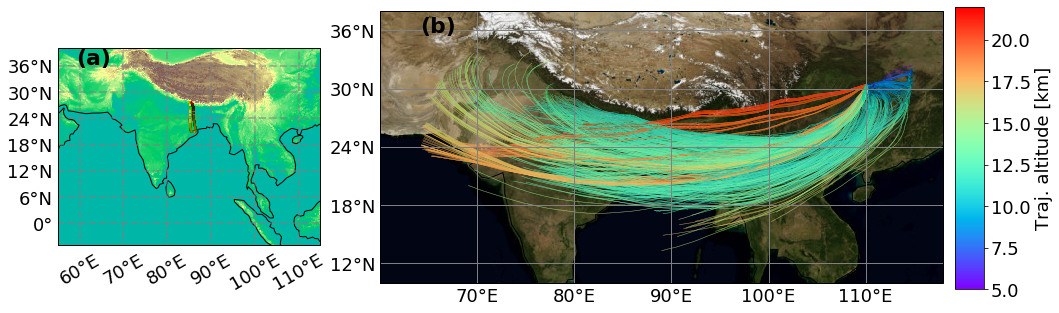

In [14]:
fs = 18
fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3)
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
ax0.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,10))
print(dset['topography_c'].max())
ax0.coastlines()
ax0.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())
ax0.text(0.07,0.92,'(a)',weight='bold',fontsize=fs+4,transform=ax0.transAxes)

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs, 'rotation': 30}
gl.ylabel_style = {'size': fs}

# Pulling from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
# Create a set of line segments so that we can color them individually
points = np.array([lon_sc[i_sc[:,0]],lat_sc[i_sc[:,0]]]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

# Convert the times from np.datetime64 to float
t_sc1 = t_sc[i_sc[:,0]]
t_sc_f = t_sc1.astype("float")/1000000000.0
t_sc_f = t_sc_f - np.nanmin(t_sc_f)
norm = plt.Normalize(t_sc_f.min(),t_sc_f.max())
lc = LineCollection(segments,cmap=cm.autumn,norm=norm)
lc.set_array(t_sc_f)
lc.set_linewidth(2)
ax0.add_collection(lc)

ax1 = fig.add_subplot(gs[0,1:], projection=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,color='gray')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':fs}
gl.ylabel_style = {'size':fs}

ax1.set_xlabel(r'Latitude [$^{\circ}$N]',fontsize=fs)
ax1.set_ylabel(r'Longitude [$^{\circ}$E]',fontsize=fs)

ax1.set_extent([60,118,10,38],crs=ccrs.PlateCarree()) # large domain
ax1.coastlines()
ax1.background_img(name='BM',resolution='high')
norm = plt.Normalize(5,22)

# How many trajectories to plot?
n = 700
for i in np.arange(n):
    # Create a set of line segments to color individually. Points in N x 1 x 2 array.
    points = np.array([traj_lon[:,i],traj_lat[:,i]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments,cmap='rainbow',norm=norm)
    lc.set_array(traj_alt[:,i])
    lc.set_linewidth(0.5)
    line = ax1.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap='rainbow',norm=norm)
sm.set_array([])
ax = plt.gca()
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])

fig.canvas.mpl_connect('resize_event', resize_colorbar)
c = plt.colorbar(sm,cax=cbar_ax)
c.set_label('Traj. altitude [km]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
resize_colorbar(None)
ax1.text(0.07,0.92,'(b)',weight='bold',fontsize=fs+4,transform=ax1.transAxes)

fig.savefig('output/1-topography-traj.png',bbox_inches='tight')
plt.show()

# Figure 2: Updraft velocity PDF + gravity wave spectrum

In [3]:
# Load the observational w values and evaluate their histogram.
basedir = '/work/bb1018/b380873/tropic_vis/obs/POSIDON/'
posidon_winds = pd.read_csv(basedir + 'posidon_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
posidon_winds = posidon_winds[(posidon_winds['z'] >= 15)]
w_obs = posidon_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_POSIDON, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('POSIDON campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

basedir = '/work/bb1018/b380873/tropic_vis/obs/ATTREX/'
attrex_winds = pd.read_csv(basedir + 'attrex3_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
attrex_winds = attrex_winds[(attrex_winds['z'] >= 15)]
w_obs = attrex_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_ATTREX, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('ATTREX campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

POSIDON campaign (mean, std) w: 0.08748738843285492 0.5858340614769502
ATTREX campaign (mean, std) w: -0.06651030636098923 0.23498594232830203


In [4]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Number of POSIDON flights (9)
posidon_dates = posidon_winds['date'].unique()

# Calculate the power spectral density of observational temperature and updraft signals.
T_PSD_POSIDON = np.zeros((len(posidon_dates), n))
w_PSD_POSIDON = np.zeros((len(posidon_dates), n))

for j, date in enumerate(posidon_dates):
    subset = posidon_winds[(posidon_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 11176, 10480, 11190, 16964, 16208, 15551, 9612, 15899, 10114
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()
    
    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_POSIDON[j] = f(freq)
    w_PSD_POSIDON[j] = f2(freq)

In [5]:
# Number of ATTREX flights (6)
attrex_dates = attrex_winds['date'].unique()

# Calculate the power spectral density of observational temperature signals.
T_PSD_ATTREX = np.zeros((len(attrex_dates), n))
w_PSD_ATTREX = np.zeros((len(attrex_dates), n))

for j, date in enumerate(attrex_dates):
    subset = attrex_winds[(attrex_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 39731, 37179, 32700, 46743, 50830, 36647
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()

    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_ATTREX[j] = f(freq)
    w_PSD_ATTREX[j] = f2(freq)

In [6]:
# Load the trajectory frequencies and power spectral densities
T_ff_0V2M0A0R = np.load('output/T_PSD_ff_0V2M0A0R_traj_ICON.npy')
T_Pxx_0V2M0A0R = np.load('output/T_PSD_Pxx_0V2M0A0R_traj_ICON.npy')

T_ff_0V2M0A0R_Tf = np.load('output/T_PSD_ff_0V2M0A0R_traj_Tf2.npy')
T_Pxx_0V2M0A0R_Tf = np.load('output/T_PSD_Pxx_0V2M0A0R_traj_Tf2.npy')

w_ff_0V2M0A0R = np.load('output/w_PSD_ff_0V2M0A0R_traj_ICON.npy')
w_Pxx_0V2M0A0R = np.load('output/w_PSD_Pxx_0V2M0A0R_traj_ICON.npy')

# Load the updraft histograms from the ICON high-resolution simulations
h_0V2M0A0R = np.load('./output/traj_w_histogram_ICON_0V2M0A0R.npy')
h_0V2M0A0R_1015km = np.load('./output/traj_w_histogram_ICON_0V2M0A0R_10-15km.npy')

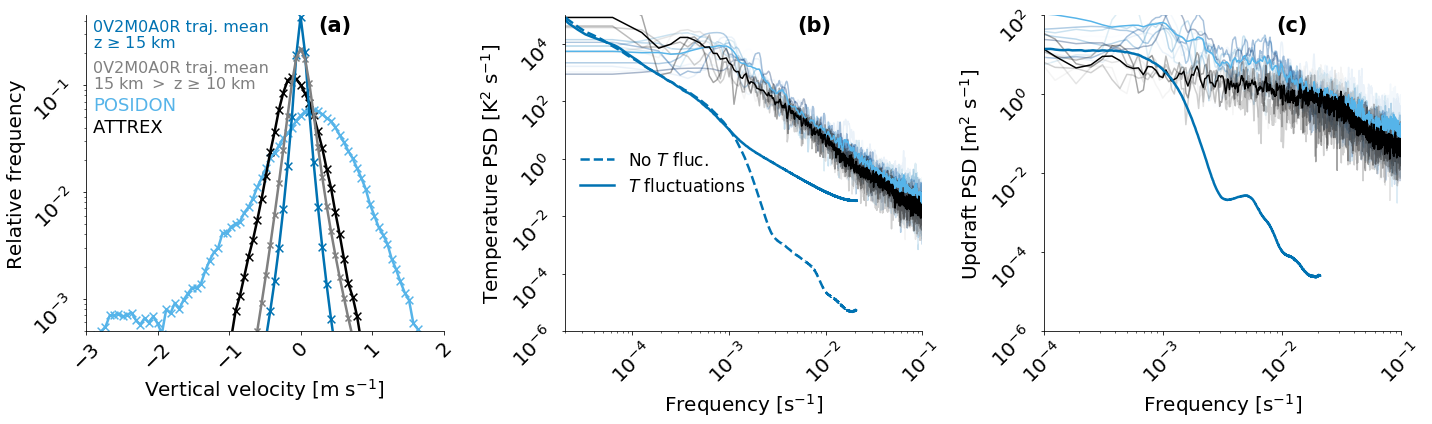

In [19]:
fs = 20
lw = 2.5
ms = 60

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_POSIDON, color=farbe['POSIDON'], lw=lw) # label='POSIDON'
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_ATTREX, color=farbe['ATTREX'], lw=lw) # label='ATTREX'
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_POSIDON, s=ms, marker='x', color=farbe['POSIDON'])
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_ATTREX, s=ms, marker='x', color=farbe['ATTREX'])

ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R,axis=0), lw=lw, color=farbe['0V2M0A0R']) # label='Traj. mean'
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R_1015km,axis=0), lw=lw, color='grey')
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R,axis=0), s=ms, marker='x', color=farbe['0V2M0A0R'])
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R_1015km,axis=0), marker='x', color='grey')

ax[0].text(0.65,0.95,'(a)', weight='bold', fontsize=fs+1, color='k', transform=ax[0].transAxes)
ax[0].text(0.02,0.95, '0V2M0A0R traj. mean', fontsize=fs-4, color=farbe['0V2M0A0R'], transform=ax[0].transAxes)
ax[0].text(0.02,0.90, 'z $≥$ 15 km', fontsize=fs-4, color=farbe['0V2M0A0R'], transform=ax[0].transAxes)
ax[0].text(0.02,0.82, r'0V2M0A0R traj. mean', fontsize=fs-4, color='grey', transform=ax[0].transAxes)
ax[0].text(0.02,0.77, '15 km $>$ z $≥$ 10 km', fontsize=fs-4, color='grey', transform=ax[0].transAxes)
ax[0].text(0.02,0.7, 'POSIDON', fontsize=fs-2, color=farbe['POSIDON'], transform=ax[0].transAxes)
ax[0].text(0.02,0.63, 'ATTREX', fontsize=fs-2, color=farbe['ATTREX'], transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].spines['right'].set_color('none')
ax[0].set_ylim([0.0005, 0.45])
ax[0].set_xlim([-3, 2])
ax[0].set_xlabel(r'Vertical velocity [m s$^{-1}$]',fontsize=fs)
ax[0].set_ylabel('Relative frequency',fontsize=fs)
sexy_axes(ax[0], fs)

colors = plt.cm.Blues(np.linspace(0,1,len(posidon_dates)))
for j in np.arange(len(posidon_dates)):
    ax[1].plot(freq, T_PSD_POSIDON[j], color=colors[j], alpha=0.35)
    ax[2].plot(freq, w_PSD_POSIDON[j], color=colors[j], alpha=0.35)
colors = plt.cm.Greys(np.linspace(0,1,len(attrex_winds['date'].unique())))   
for j in np.arange(len(attrex_dates)):
    ax[1].plot(freq, T_PSD_ATTREX[j], color=colors[j], alpha=0.35)
    ax[2].plot(freq, w_PSD_ATTREX[j], color=colors[j], alpha=0.35)
    
ax[1].plot(freq, np.nanmean(T_PSD_POSIDON,axis=0), color=farbe['POSIDON'], linewidth=lw-1)
ax[1].plot(freq, np.nanmean(T_PSD_ATTREX,axis=0), color=farbe['ATTREX'], linewidth=lw-1)
ax[2].plot(freq, np.nanmean(w_PSD_POSIDON,axis=0), color=farbe['POSIDON'], linewidth=lw-1)
ax[2].plot(freq, np.nanmean(w_PSD_ATTREX,axis=0), color=farbe['ATTREX'], linewidth=lw-1)
ax[1].text(0.65,0.95,'(b)',weight='bold',fontsize=fs+1,color='k',transform=ax[1].transAxes)
ax[2].text(0.65,0.95,'(c)',weight='bold',fontsize=fs+1,color='k',transform=ax[2].transAxes)

#colors = plt.cm.Blues(np.linspace(0,1,30))
# Very limited variability between the files
#for j in np.arange(25):
#    ax[1].plot(T_ff_0V2M0A0R_Tf[j], T_Pxx_0V2M0A0R_Tf[j], color=colors[j], alpha=0.2)
ax[1].plot(np.nanmean(T_ff_0V2M0A0R,axis=0), np.nanmean(T_Pxx_0V2M0A0R,axis=0), ls='--', label=r'No $T$ fluc.', lw=lw, color=farbe['0V2M0A0R'])
ax[1].plot(np.nanmean(T_ff_0V2M0A0R_Tf,axis=0), np.nanmean(T_Pxx_0V2M0A0R_Tf,axis=0), label=r'$T$ fluctuations', lw=lw, color=farbe['0V2M0A0R'])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([2*10**-5, 0.1])
ax[1].set_ylim([10**-6, 10**5])
ax[1].legend(loc='center left', frameon=False, fontsize=fs-3)
ax[1].set_ylabel(r'Temperature PSD [K$^2$ s$^{-1}$]',fontsize=fs)
ax[1].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[1], fs)

#for j in np.arange(30):
#    ax[2].plot(w_ff_0V2M0A0R[j], w_Pxx_0V2M0A0R[j], color=colors[j], alpha=0.35)
ax[2].plot(np.nanmean(w_ff_0V2M0A0R,axis=0), np.nanmean(w_Pxx_0V2M0A0R,axis=0), linewidth=lw, color=farbe['0V2M0A0R'])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlim([10**-4, 0.1])
ax[2].set_ylim([10**(-6), 10**2])
ax[2].set_ylabel(r'Updraft PSD [m$^2$ s$^{-1}$]',fontsize=fs)
ax[2].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[2], fs)

plt.tight_layout()
fig.savefig('./output/traj_dynamics.pdf',bbox_inches='tight')
plt.show()

# Figure 3: Temperature and specific humidity profile comparisons

In [3]:
# Time range from Lee et al. 2019 (6:20-6:48 UTC)
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)
# Full flight track times
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

# Read in-situ data
alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data altitudinally
min_alt = 14000  # 5000
max_alt = 22000
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( min_alt, max_alt, alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, \
                    rhice_fish )

In [11]:
# Which set of trajectory statistics do you want to open?

tag = ''  # Default 625 synthetic trajectories
#tag = '_fixed' # Fix the number of elements per bin to that of the in-situ measurements
#tag = '_2' # Second set of 625 synthetic trajectories to test reproducibility
#tag = '_collocate' # Minimize the Euclidean distance between sim and obs values
#tag = '_pinpoint' # Find the closest numerical value to the obs within the sim

stats1 = np.load('output/ICON_syntrajs_0V1M0A0R_stats' + tag + '.npy')  #'ICON_syntrajs_0V1M0A0R_stats_70bins.npy'
stats2 = np.load('output/ICON_syntrajs_0V2M0A0R_stats' + tag + '.npy')  #'ICON_syntrajs_0V2M0A0R_stats_70bins.npy'
stats3 = np.load('output/ICON_syntrajs_0V2M1A1R_stats' + tag + '.npy')  #'ICON_syntrajs_0V2M1A1R_stats_70bins.npy'

warnings.filterwarnings(action='once')
sim_stats = np.stack((stats1, stats2, stats3))
sim_list = ['0V1M0A0R', '0V2M0A0R', '0V2M1A1R']

In [12]:
# Calculate the potential temperature from the pure temperature
#n = 70
n = 13
theta_ICON = np.empty((3, 3, n, 625))
theta_ICON[:] = np.nan
RH_ICON = np.empty((3, 3, n, 625))
RH_ICON[:] = np.nan

theta_ICON = calc_theta(sim_stats[:,0], sim_stats[:,1])
RH_ICON = calc_RH(sim_stats[:,0], sim_stats[:,1], sim_stats[:,2])

/mnt/lustre02/work/bb1018/b380873/tropic_vis/thermodynamic_functions.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return qv / qsat * 100


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0.03, 0.93, '(d)')

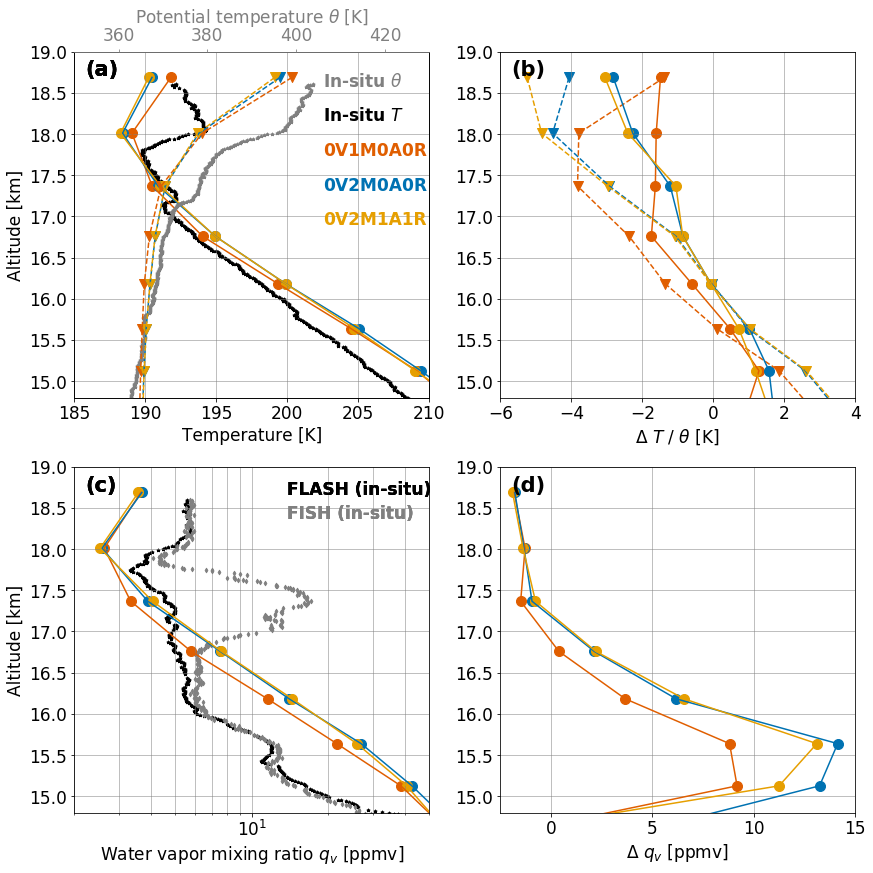

In [13]:
fs = 17
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
y1 = 14.8
y2 = 19
icon_sz = 100
icon_lw = 1.5
icon_alfa = 1
k = 0 # If k = 0, compare means. If k = 1, compare medians.

# Whether we look at stats or stats_fixed is set above.
ax[0,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[0,0].scatter(temp, alt3/1000, color='k', s=10, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    # np.linspace(u,d,n)/1000 were the initial y-coordinates
    ax[0,0].scatter(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1), bins_sims/1000, s=icon_sz, color=farbe[s_name])
    ax[0,0].plot(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1), bins_sims/1000, linewidth=icon_lw, color=farbe[s_name])
    ax[0,0].set_ylim([y1, y2])
    ax[0,0].set_xlim([185, 210])
    ax[0,0].tick_params('both',labelsize=fs)
    ax[0,0].set_xlabel('Temperature [K]', fontsize=fs)
    ax[0,0].set_ylabel('Altitude [km]',fontsize=fs)
    ax[0,0].text(0.03, 0.93, '(a)', weight='bold', fontsize=fs+4, transform=ax[0,0].transAxes)

ax0 = ax[0,0].twiny()
ax0.scatter(theta, alt3/1000, color='gray', s=10, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    ax0.scatter(np.nanmean(theta_ICON[s_indx,k,:,:20], axis=1), bins_sims/1000, marker='v', s=icon_sz, color=farbe[s_name])
    ax0.plot(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1), bins_sims/1000, ls='--', linewidth=icon_lw, color=farbe[s_name])
ax0.set_xlabel(r'Potential temperature $\theta$ [K]', fontsize=fs, color='gray')
ax0.spines['top'].set_color('gray')
ax0.tick_params(axis='x',colors='gray')
ax0.set_xlim([350, 430])
ax0.tick_params('both',labelsize=fs)
ax0.text(0.7, 0.9, r'In-situ $\theta$', fontsize=fs, weight='bold', color='gray', transform=ax0.transAxes)
ax0.text(0.7, 0.8, r'In-situ $T$', fontsize=fs, weight='bold', color='black', transform=ax0.transAxes)
ax0.text(0.7, 0.7, '0V1M0A0R', fontsize=fs, weight='bold', color=farbe['0V1M0A0R'], transform=ax0.transAxes)
ax0.text(0.7, 0.6, '0V2M0A0R', fontsize=fs, weight='bold', color=farbe['0V2M0A0R'], transform=ax0.transAxes)
ax0.text(0.7, 0.5, '0V2M1A1R', fontsize=fs, weight='bold', color=farbe['0V2M1A1R'], transform=ax0.transAxes)

ax[0,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[0,1].scatter(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1) - temp_SC_stats[k], bins_sims/1000,
                   s=icon_sz, alpha=icon_alfa, color=farbe[s_name])
    ax[0,1].plot(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1) - temp_SC_stats[k], bins_sims/1000,
                 linewidth=icon_lw, color=farbe[s_name])
    ax[0,1].scatter(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1) - theta_SC_stats[k], bins_sims/1000,
                    s=icon_sz, marker='v', alpha=icon_alfa, color=farbe[s_name])
    ax[0,1].plot(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1) - theta_SC_stats[k], bins_sims/1000,
                  linewidth=icon_lw, ls='--', color=farbe[s_name])
ax[0,1].set_ylim([y1, y2])
ax[0,1].set_xlim([-6, 4])
ax[0,1].tick_params('both',labelsize=fs)
ax[0,1].set_xlabel(r'$\Delta$ $T$ / $\theta$ [K]', fontsize=fs)
ax[0,1].text(0.03, 0.93, '(b)', weight='bold', fontsize=fs+4, transform=ax[0,1].transAxes)

ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[1,0].scatter(qv_flash, alt1/1000, color='k', s=10, marker='*')
ax[1,0].scatter(qv_fish, alt1/1000, color='gray', s=10, marker='d')
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1), bins_sims/1000, s=icon_sz, color=farbe[s_name])
    ax[1,0].plot(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1), bins_sims/1000, linewidth=icon_lw, color=farbe[s_name])
    ax[1,0].set_xlabel('Water vapor mixing ratio $q_v$ [ppmv]',fontsize=fs)
    ax[1,0].set_ylabel('Altitude [km]',fontsize=fs)
    ax[1,0].set_xlim(2,50)
    ax[1,0].set_ylim([y1, y2])
    ax[1,0].set_xscale('log')
    ax[1,0].text(0.6, 0.92, 'FLASH (in-situ)', fontsize=fs, weight='bold', transform=ax[1,0].transAxes)
    ax[1,0].text(0.6, 0.85, 'FISH (in-situ)', fontsize=fs, weight='bold', color='gray', transform=ax[1,0].transAxes)
    ax[1,0].tick_params('both', labelsize=fs)
    ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1) - qv_flash_SC_stats[k], bins_sims/1000,
                    s=icon_sz, alpha=icon_alfa, color=farbe[s_name])
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1) - qv_flash_SC_stats[k], bins_sims/1000,
                  linewidth=icon_lw, color=farbe[s_name])
ax[1,1].set_ylim([y1, y2])
if tag == '_pinpoint':
    ax[1,1].set_xlim([-2.5, 2.5])
else:
    ax[1,1].set_xlim([-2.5, 15])
ax[1,1].tick_params('both', labelsize=fs)
ax[1,1].set_xlabel(r'$\Delta$ $q_v$ [ppmv]', fontsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/T-theta-qv-comp' + tag + '.pdf')

# Figure 4: Relative humidity and ice mass mixing ratio profile comparisons

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


Text(0.03, 0.93, '(d)')

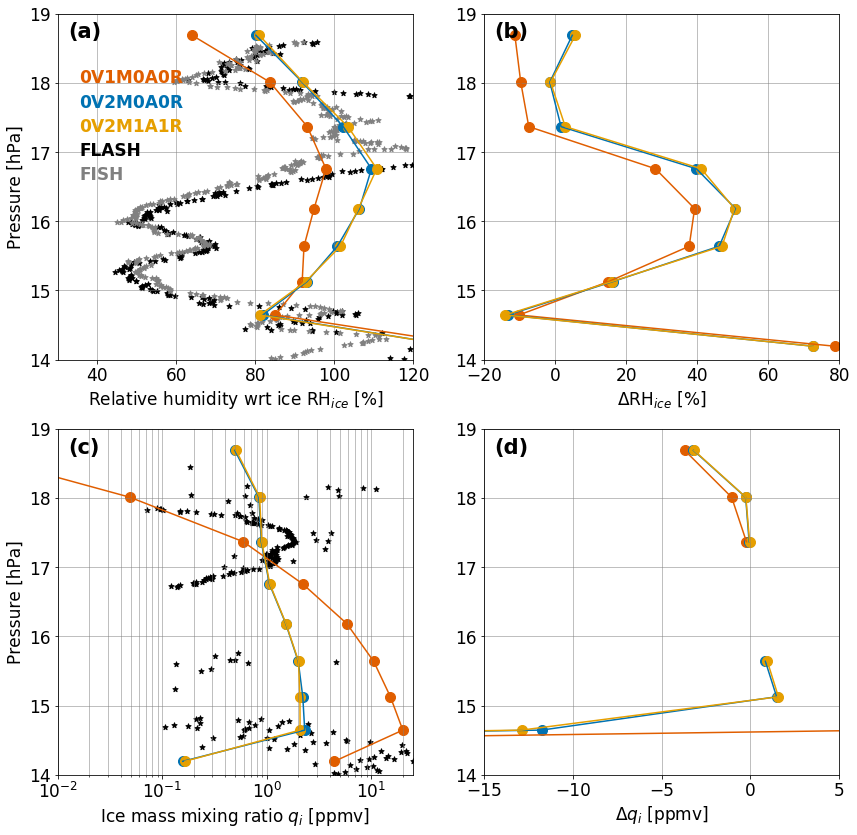

In [14]:
fs = 17
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
y1 = 14
y2 = 19
icon_sz = 100
icon_lw = 1.5
icon_alfa = 1
k = 0 # If k = 0, compare means. If k = 1, compare medians.

ax[0,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[0,0].scatter(rhice_fish, alt4/1000, color='k', s=30, marker='*')
ax[0,0].scatter(rhice_flash, alt4/1000, color='gray', s=30, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    ax[0,0].scatter(np.nanmean(RH_ICON[s_indx,k], axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,0].plot(np.nanmean(RH_ICON[s_indx,k], axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
ax[0,0].text(0.06, 0.8, '0V1M0A0R', fontsize=fs, weight='bold', color=farbe['0V1M0A0R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.73, '0V2M0A0R', fontsize=fs, weight='bold', color=farbe['0V2M0A0R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.66, '0V2M1A1R', fontsize=fs, weight='bold', color=farbe['0V2M1A1R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.59, 'FLASH', fontsize=fs, weight='bold', transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.52, 'FISH', fontsize=fs, weight='bold', color='gray', transform=ax[0,0].transAxes)
ax[0,0].set_ylim([y1, y2])
ax[0,0].set_xlim([30, 120])
ax[0,0].set_xlabel(r'Relative humidity wrt ice RH$_{ice}$ [%]', fontsize=fs)
ax[0,0].set_ylabel('Pressure [hPa]', fontsize=fs)
ax[0,0].tick_params('both',labelsize=fs)
ax[0,0].text(0.03, 0.93, '(a)', weight='bold', fontsize=fs+4, transform=ax[0,0].transAxes)

ax[0,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[0,1].scatter(np.nanmean(RH_ICON[s_indx,k], axis=1) - RHi_SC_stats[k], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,1].plot(np.nanmean(RH_ICON[s_indx,k], axis=1) - RHi_SC_stats[k], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
ax[0,1].set_ylim([y1, y2])
if tag == '_pinpoint':
    ax[0,1].set_xlim([-20, 20])
else:
    ax[0,1].set_xlim([-20, 80])
ax[0,1].set_xlabel(r'$\Delta$RH$_{ice}$ [%]', fontsize=fs)
ax[0,1].tick_params('both',labelsize=fs)
ax[0,1].text(0.03, 0.93, '(b)', weight='bold', fontsize=fs+4, transform=ax[0,1].transAxes)

ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[1,0].scatter(qi, alt2/1000, color='k', s=30, marker='*')

# We don't use k below because we are showing both the mean and median always.
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    #ax[1,0].scatter(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    #ax[1,0].plot(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,0].set_ylim([y1, y2])
ax[1,0].set_xlim([0.01, 25])
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[1,0].tick_params('both',labelsize=fs)
ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)
ax[1,0].set_ylabel('Pressure [hPa]', fontsize=fs)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    #ax[1,1].scatter(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    #ax[1,1].plot(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,1].set_ylim([y1, y2])
if tag == '_pinpoint':
    ax[1,1].set_xlim([-5, 5])
else:
    ax[1,1].set_xlim([-15, 5])
#ax[1,1].set_xscale('log')
ax[1,1].set_xlabel(r'$\Delta q_i$ [ppmv]', fontsize=fs)
ax[1,1].tick_params('both',labelsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/RHi-qi-comp' + tag + '.pdf')

# Figure 5: Density plots of ice crystal size and temperature from trajectories